In [2]:
from matplotlib import pyplot as plt
import scipy as sc
import pandas
import math
import numpy as np
import lmfit
import os
from uncertainties import ufloat
import array_to_latex as atl
from uncertainties import unumpy as up

In [3]:
plt.rc ('font', size = 15) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 15) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 15) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 15) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 15) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 15) #Schriftgröße der Legende

In [4]:
def pos(x,pos):
    for i in range(len(pos)):
        if pos[i]>=x:
            return i
            break

In [5]:
def gaus1fit(von,bis,path,x,y,err,yscale,nrmx=True,m=1,mmin=0,mmax=2,s=0.2,smax=1000,scale=1e-9,override=False): 

            
    data=[x,y,err]
    vonarr = pos(von,x)
    bisarr = pos(bis,x)

    model_gaus = lmfit.models.GaussianModel()  
    pars_gaus=model_gaus.guess(data=y[vonarr:bisarr],x=x[vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["center"].set(value=m,min=mmin,max=mmax)
        pars_gaus["sigma"].set(value=1,min=0)
        pars_gaus["amplitude"].set(value=1,min=0)


    #Fitten
    out_gaus = model_gaus.fit(y[vonarr:bisarr],x=x[vonarr:bisarr],weights=1/err[vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(8,6),dpi=80,linewidth=50)
    plt.errorbar(x[vonarr:bisarr],yscale*y[vonarr:bisarr],yerr=yscale*err[vonarr:bisarr],fmt='.',ecolor='gray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.errorbar(x[0:vonarr],yscale*y[0:vonarr],yerr=yscale*err[0:vonarr],fmt='.',ecolor='gray',color='b', elinewidth=3, capsize=0,zorder=5)
    plt.errorbar(x[bisarr:-1],yscale*y[bisarr:-1],yerr=yscale*err[bisarr:-1],fmt='.',ecolor='gray',color='b', elinewidth=3, capsize=0,zorder=5)

    if nrmx:
        plt.plot(np.arange(26,29,0.01),yscale*out_gaus.eval(x=np.arange(26,29,0.01)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Gaus-Fit")
    else:
        plt.plot(np.arange(27,29,0.01),yscale*out_gaus.eval(x=np.arange(27,29,0.01)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Gaus-Fit")

    plt.grid()
    plt.xlabel('Masse zu Ladungsverhältniss [amu]')
    plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())


    return np.array([np.arange(26,29,0.01),out_gaus.eval(x=np.arange(26,29,0.01))]), out_gaus

def gaus2fit(von,bis,path,x,y,err,yscale,override=False,m1=1,s1=1,scale1=1,m2=1,s2=1,scale2=1,m1min=1,m1max=1,m2min=1,m2max=1): 


    data=[x,y,err]
    vonarr = pos(von,x)
    bisarr = pos(bis,x)



    model_gaus=lmfit.models.GaussianModel(prefix="g1_")+lmfit.models.GaussianModel(prefix="g2_")

    def guess(data,x):
        params_g1=lmfit.models.GaussianModel(prefix="g1_").guess(y,x)
        params=model_gaus.make_params()
        for i in params_g1:
            params[i]=params_g1[i]
                    
        params["g2_center"].value=params.get("g1_center").value-1
        params["g2_sigma"].value=params.get("g1_sigma").value*0.5
        params["g2_amplitude"].value=params.get("g1_amplitude").value*0.3
        return params

    model_gaus.guess=guess
    pars_gaus = model_gaus.guess(data=y[vonarr:bisarr],x=x[vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["g1_center"].set(value=m1,min=m1min,max=m1max)
        pars_gaus["g1_sigma"].set(value=s1)
        pars_gaus["g1_amplitude"].set(value=scale1,min=0)
        pars_gaus["g2_center"].set(value=m2,min=m2min,max=m2max)
        pars_gaus["g2_sigma"].set(value=s2)
        pars_gaus["g2_amplitude"].set(value=scale2,min=0)


    #Fitten
    out_gaus = model_gaus.fit(y[vonarr:bisarr],x=x[vonarr:bisarr],weights=1/err[vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(8,6),dpi=80,linewidth=50)
    plt.errorbar(x[vonarr:bisarr],yscale*y[vonarr:bisarr],yerr=yscale*err[vonarr:bisarr],fmt='o',ecolor='gray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.errorbar(x[0:vonarr],yscale*y[0:vonarr],yerr=yscale*err[0:vonarr],fmt='.',ecolor='gray',color='b', elinewidth=3, capsize=0,zorder=5)
    plt.errorbar(x[bisarr:-1],yscale*y[bisarr:-1],yerr=yscale*err[bisarr:-1],fmt='.',ecolor='gray',color='b', elinewidth=3, capsize=0,zorder=5)
    plt.plot(np.arange(26,29,0.01),yscale*out_gaus.eval(x=np.arange(26,29,0.01)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Gaus-Fit")
    
    plt.xlabel('Masse zu Ladungsverhältniss [amu]')
    plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
    plt.grid()
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())

    return np.array([np.arange(26,29,0.01), out_gaus.eval(x=np.arange(26,29,0.01))]),out_gaus

In [6]:
fig = plt.figure(figsize=(20,10),dpi=80,linewidth=50)
x = [[],[],[]]
data = []
err = []
for i in range(len(os.listdir('Data'))):
    path = 'Data/'+os.listdir('Data')[i]
    print(path)
    with open(path) as tf:
        dataex = np.genfromtxt((line.replace(',', '.') for line in tf),delimiter=";",skip_header=21).T
        if len(dataex[3])==151:
            x[0] = dataex[3]
        elif len(dataex[3])==101:
            x[1] = dataex[3]
        elif len(dataex[3])==201:
            x[2] = dataex[3] 
        else:
            print('Error')
        
        data.append(dataex[4])
        err.append(dataex[4]*0.05)


Data/11Deltam -0%.csv
Data/12Deltam -10%.csv
Data/13Deltam -20%.csv
Data/14Deltam -30%.csv
Data/15Deltam -40%.csv
Data/16Deltam -50%.csv
Data/17Deltam -60%.csv
Data/18Deltam -70%.csv
Data/19Deltam -80%.csv
Data/20Deltam -90%.csv
Data/21Deltam -100%.csv
Data/22Deltam -100%V2.csv
Data/22Deltam 10%.csv
Data/23Deltam 20%.csv
Data/24Deltam 30%.csv
Data/25Deltam 40%.csv
Data/26Deltam 50%.csv
Data/27Deltam 60%.csv
Data/28Deltam 70%.csv
Data/30Deltam 80%.csv
Data/31Deltam 90%.csv
Data/32Deltam 100%.csv


<Figure size 1600x800 with 0 Axes>

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 41
    # variables        = 3
    chi-square         = 951.500910
    reduced chi-square = 25.0394976
    Akaike info crit   = 134.923212
    Bayesian info crit = 140.063928
[[Variables]]
    amplitude:  4.3402e-08 +/- 1.7979e-09 (4.14%) (init = 5.672508e-08)
    center:     28.0894433 +/- 0.00846782 (0.03%) (init = 28.13)
    sigma:      0.20061767 +/- 0.00664801 (3.31%) (init = 0.23)
    fwhm:       0.47241850 +/- 0.01565487 (3.31%) == '2.3548200*sigma'
    height:     8.6308e-08 +/- 5.0224e-09 (5.82%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)    = -0.565
    C(amplitude, sigma) = -0.208


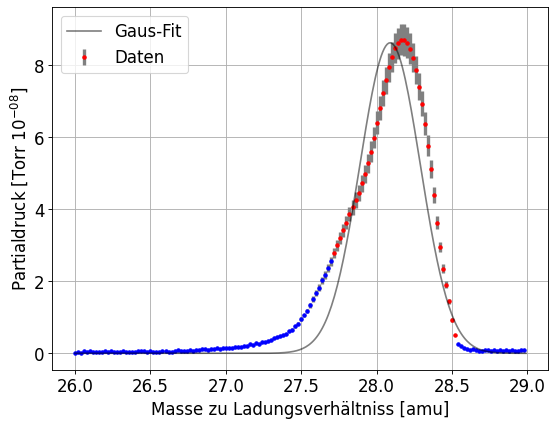

In [7]:
fit0 = gaus1fit(27.72,28.53,'0%',x[0],data[0],err[0],1e8)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 46
    # variables        = 3
    chi-square         = 549.194546
    reduced chi-square = 12.7719662
    Akaike info crit   = 120.071322
    Bayesian info crit = 125.557246
[[Variables]]
    amplitude:  6.6449e-08 +/- 1.8191e-09 (2.74%) (init = 7.70772e-08)
    center:     28.0623522 +/- 0.00595254 (0.02%) (init = 28.11)
    sigma:      0.23463227 +/- 0.00556266 (2.37%) (init = 0.25)
    fwhm:       0.55251676 +/- 0.01309906 (2.37%) == '2.3548200*sigma'
    height:     1.1298e-07 +/- 4.4997e-09 (3.98%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)    = -0.336
    C(amplitude, sigma) = -0.212


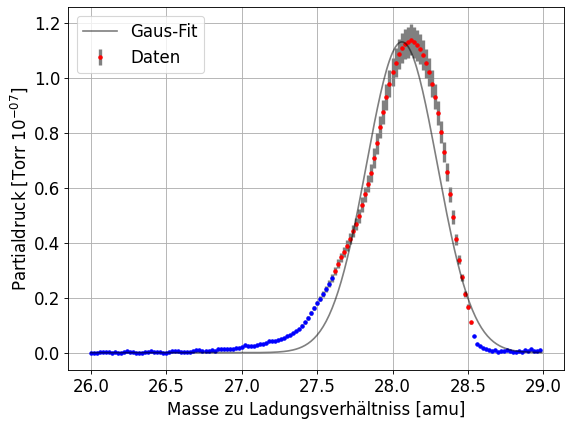

In [8]:
fit_10 = gaus1fit(27.62,28.53,'-10%',x[0],data[1],err[1],1e7)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 55
    # variables        = 3
    chi-square         = 704.920997
    reduced chi-square = 13.5561730
    Akaike info crit   = 146.291390
    Bayesian info crit = 152.313390
[[Variables]]
    amplitude:  1.0218e-07 +/- 2.9010e-09 (2.84%) (init = 1.302635e-07)
    center:     28.0431587 +/- 0.00446631 (0.02%) (init = 28.07)
    sigma:      0.23486286 +/- 0.00375173 (1.60%) (init = 0.27)
    fwhm:       0.55305976 +/- 0.00883464 (1.60%) == '2.3548200*sigma'
    height:     1.7356e-07 +/- 6.6389e-09 (3.83%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = -0.443
    C(amplitude, center) = 0.108


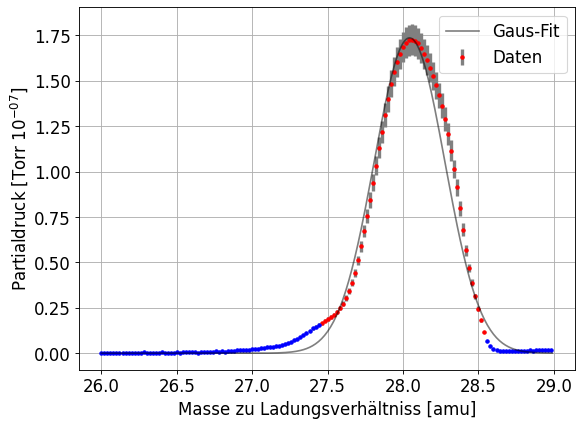

In [9]:
fit_20 = gaus1fit(27.45,28.55,'-20%',x[0],data[2],err[2],1e7)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 67
    # variables        = 3
    chi-square         = 1740.25444
    reduced chi-square = 27.1914757
    Akaike info crit   = 224.225298
    Bayesian info crit = 230.839375
[[Variables]]
    amplitude:  1.5535e-07 +/- 5.9094e-09 (3.80%) (init = 2.154552e-07)
    center:     27.9538982 +/- 0.00636839 (0.02%) (init = 28.02)
    sigma:      0.26666266 +/- 0.00479528 (1.80%) (init = 0.32)
    fwhm:       0.62794256 +/- 0.01129202 (1.80%) == '2.3548200*sigma'
    height:     2.3241e-07 +/- 1.1483e-08 (4.94%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = -0.490
    C(amplitude, center) = 0.189
    C(center, sigma)     = -0.187


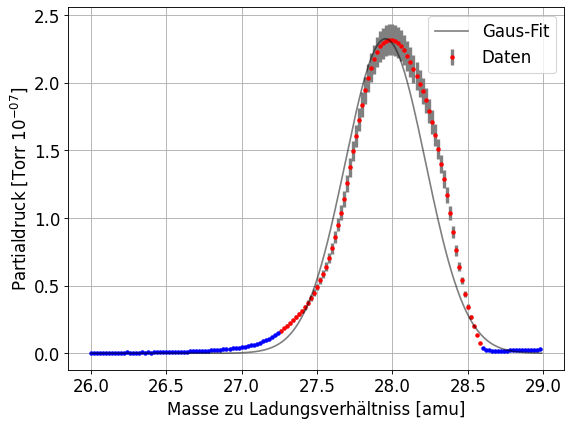

In [10]:
fit_30 = gaus1fit(27.25,28.6,'-30%',x[0],data[3],err[3],1e7)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 75
    # variables        = 3
    chi-square         = 1299.84707
    reduced chi-square = 18.0534316
    Akaike info crit   = 219.938534
    Bayesian info crit = 226.890998
[[Variables]]
    amplitude:  2.1808e-07 +/- 6.4354e-09 (2.95%) (init = 3.053135e-07)
    center:     27.9297248 +/- 0.00530453 (0.02%) (init = 27.98)
    sigma:      0.29766710 +/- 0.00415117 (1.39%) (init = 0.36)
    fwhm:       0.70095243 +/- 0.00977525 (1.39%) == '2.3548200*sigma'
    height:     2.9228e-07 +/- 1.1224e-08 (3.84%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = -0.497
    C(center, sigma)     = 0.136
    C(amplitude, center) = 0.105


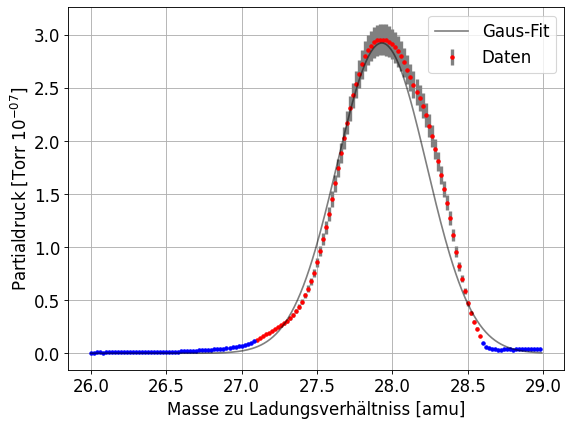

In [11]:
fit_40 = gaus1fit(27.1,28.6,'-40%',x[0],data[4],err[4],1e7)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 86
    # variables        = 3
    chi-square         = 4016.78994
    reduced chi-square = 48.3950596
    Akaike info crit   = 336.574630
    Bayesian info crit = 343.937672
[[Variables]]
    amplitude:  2.3414e-07 +/- 1.1673e-08 (4.99%) (init = 3.563126e-07)
    center:     27.9132031 +/- 0.00739633 (0.03%) (init = 27.96)
    sigma:      0.29182686 +/- 0.00533816 (1.83%) (init = 0.38)
    fwhm:       0.68719973 +/- 0.01257041 (1.83%) == '2.3548200*sigma'
    height:     3.2009e-07 +/- 1.9929e-08 (6.23%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = -0.579
    C(amplitude, center) = 0.163


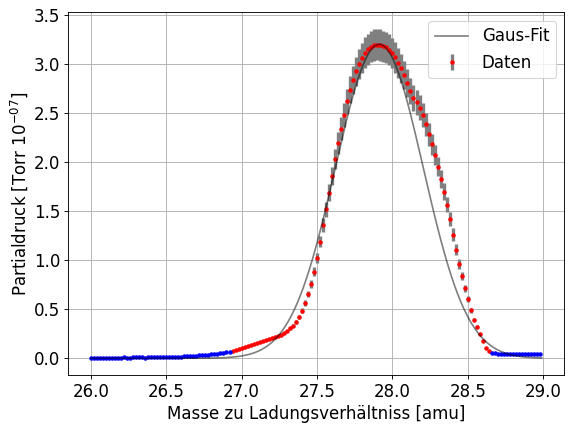

In [12]:
fit_50 = gaus1fit(26.94,28.65,'-50%',x[0],data[5],err[5],1e7)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 91
    # variables        = 3
    chi-square         = 3584.15354
    reduced chi-square = 40.7290175
    Akaike info crit   = 340.281048
    Bayesian info crit = 347.813626
[[Variables]]
    amplitude:  2.8327e-07 +/- 1.2357e-08 (4.36%) (init = 4.242752e-07)
    center:     27.8971859 +/- 0.00746121 (0.03%) (init = 27.93)
    sigma:      0.32020951 +/- 0.00554238 (1.73%) (init = 0.41)
    fwhm:       0.75403575 +/- 0.01305130 (1.73%) == '2.3548200*sigma'
    height:     3.5292e-07 +/- 1.9477e-08 (5.52%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = -0.558
    C(center, sigma)    = 0.184


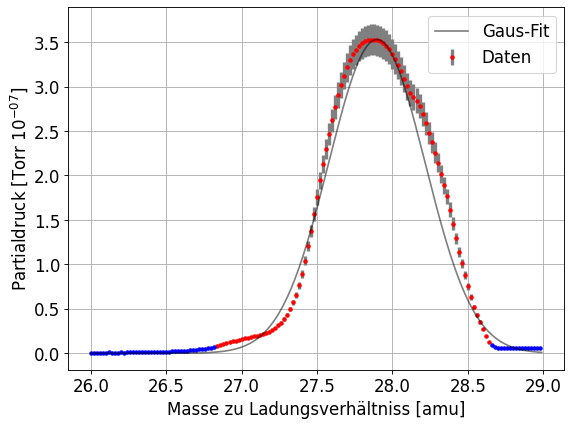

In [13]:
fit_60 = gaus1fit(26.83,28.65,'-60%',x[0],data[6],err[6],1e7)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 105
    # variables        = 3
    chi-square         = 2785.93194
    reduced chi-square = 27.3130582
    Akaike info crit   = 350.229624
    Bayesian info crit = 358.191505
[[Variables]]
    amplitude:  4.5412e-07 +/- 1.4977e-08 (3.30%) (init = 7.112693e-07)
    center:     27.8187684 +/- 0.00688035 (0.02%) (init = 27.83)
    sigma:      0.37124464 +/- 0.00457319 (1.23%) (init = 0.49)
    fwhm:       0.87421429 +/- 0.01076903 (1.23%) == '2.3548200*sigma'
    height:     4.8800e-07 +/- 1.9976e-08 (4.09%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = -0.537
    C(center, sigma)    = 0.436


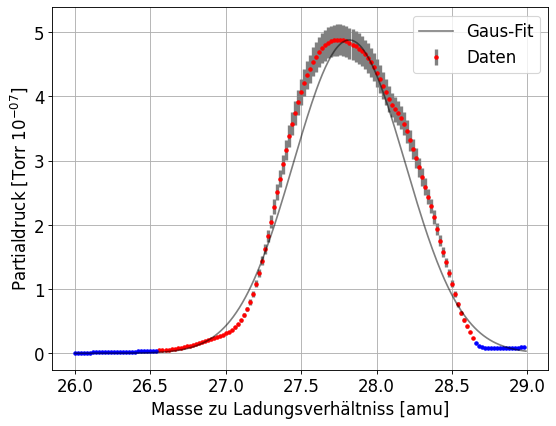

In [14]:
fit_70 = gaus1fit(26.55,28.65,'-70%',x[0],data[7],err[7],1e7)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 114
    # variables        = 3
    chi-square         = 2634.47263
    reduced chi-square = 23.7339877
    Akaike info crit   = 363.987343
    Bayesian info crit = 372.195939
[[Variables]]
    amplitude:  5.7001e-07 +/- 1.6681e-08 (2.93%) (init = 8.847917e-07)
    center:     27.7794470 +/- 0.00718073 (0.03%) (init = 27.79)
    sigma:      0.40591428 +/- 0.00450696 (1.11%) (init = 0.53)
    fwhm:       0.95585506 +/- 0.01061309 (1.11%) == '2.3548200*sigma'
    height:     5.6022e-07 +/- 2.0287e-08 (3.62%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)    = 0.543
    C(amplitude, sigma) = -0.510


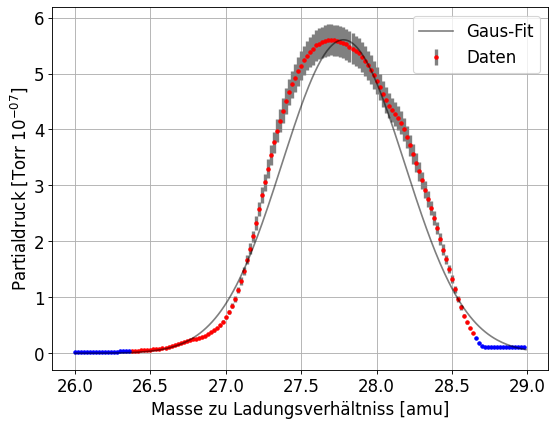

In [15]:
fit_80 = gaus1fit(26.37,28.65,'-80%',x[0],data[8],err[8],1e7)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 125
    # variables        = 3
    chi-square         = 2293.05211
    reduced chi-square = 18.7955091
    Akaike info crit   = 369.665659
    Bayesian info crit = 378.150600
[[Variables]]
    amplitude:  6.9830e-07 +/- 1.7222e-08 (2.47%) (init = 1.089797e-06)
    center:     27.7239795 +/- 0.00693663 (0.03%) (init = 27.74)
    sigma:      0.44345119 +/- 0.00406709 (0.92%) (init = 0.58)
    fwhm:       1.04424773 +/- 0.00957727 (0.92%) == '2.3548200*sigma'
    height:     6.2821e-07 +/- 1.8950e-08 (3.02%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)    = 0.602
    C(amplitude, sigma) = -0.481


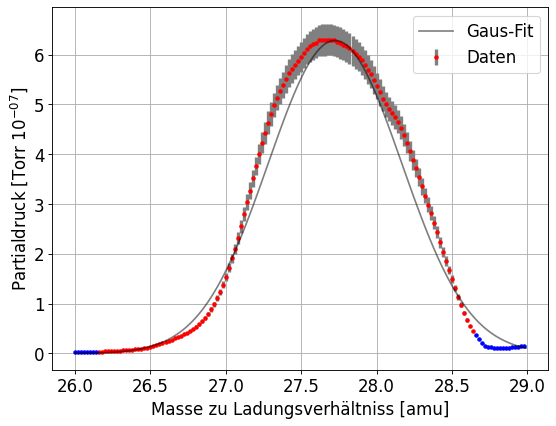

In [16]:
fit_90 = gaus1fit(26.15,28.65,'-90%',x[0],data[9],err[9],1e7)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 124
    # variables        = 3
    chi-square         = 3445.77506
    reduced chi-square = 28.4774798
    Akaike info crit   = 418.253199
    Bayesian info crit = 426.714044
[[Variables]]
    amplitude:  6.7853e-07 +/- 2.1078e-08 (3.11%) (init = 1.083043e-06)
    center:     27.7431707 +/- 0.00811991 (0.03%) (init = 27.75)
    sigma:      0.44033885 +/- 0.00525531 (1.19%) (init = 0.59)
    fwhm:       1.03691872 +/- 0.01237530 (1.19%) == '2.3548200*sigma'
    height:     6.1474e-07 +/- 2.3769e-08 (3.87%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = -0.523
    C(center, sigma)    = 0.521


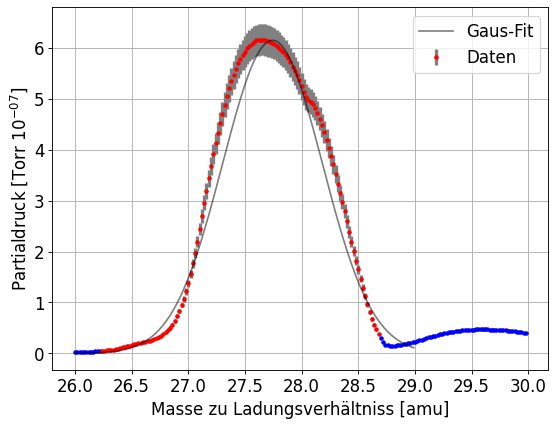

In [17]:
fit_100 = gaus1fit(26.22,28.7,'-100%',x[2],data[10],err[10],1e7)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 129
    # variables        = 3
    chi-square         = 3848.78541
    reduced chi-square = 30.5459159
    Akaike info crit   = 444.045364
    Bayesian info crit = 452.624801
[[Variables]]
    amplitude:  6.9956e-07 +/- 2.2405e-08 (3.20%) (init = 1.134149e-06)
    center:     27.7133967 +/- 0.00828692 (0.03%) (init = 27.7)
    sigma:      0.44369767 +/- 0.00511033 (1.15%) (init = 0.6)
    fwhm:       1.04482814 +/- 0.01203391 (1.15%) == '2.3548200*sigma'
    height:     6.2900e-07 +/- 2.4808e-08 (3.94%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)    = 0.562
    C(amplitude, sigma) = -0.538


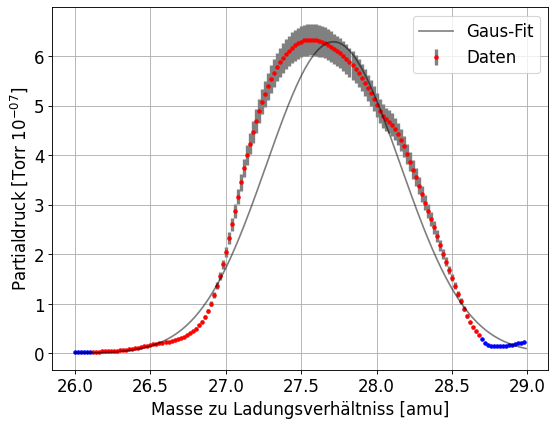

In [18]:
fit_100v2 = gaus1fit(26.12,28.7,'-100%v2',x[0],data[11],err[11],1e7)

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 142
    # data points      = 50
    # variables        = 6
    chi-square         = 39.4498632
    reduced chi-square = 0.89658780
    Akaike info crit   = 0.15037876
    Bayesian info crit = 11.6225168
[[Variables]]
    g1_amplitude:  9.7830e-09 +/- 8.0015e-10 (8.18%) (init = 1e-07)
    g1_center:     28.2547929 +/- 0.00350048 (0.01%) (init = 28.4)
    g1_sigma:      0.11300024 +/- 0.00609160 (5.39%) (init = 0.3)
    g2_amplitude:  1.9371e-08 +/- 1.1420e-09 (5.90%) (init = 3e-08)
    g2_center:     27.9817239 +/- 0.01812766 (0.06%) (init = 27.9)
    g2_sigma:      0.23843728 +/- 0.00809106 (3.39%) (init = 0.3)
    g1_fwhm:       0.26609522 +/- 0.01434463 (5.39%) == '2.3548200*g1_sigma'
    g1_height:     3.4539e-08 +/- 1.2244e-09 (3.55%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_fwhm:       0.56147689 +/- 0.01905299 (3

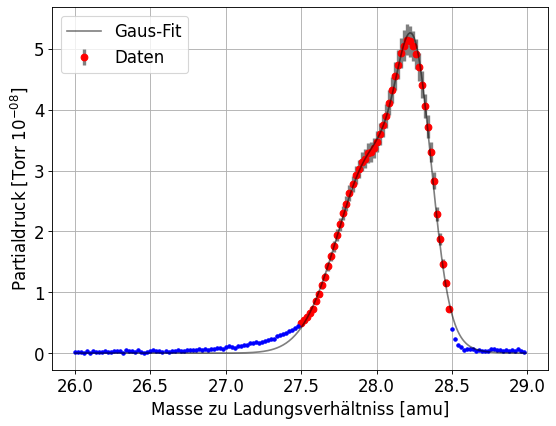

In [19]:
fit10 = gaus2fit(27.5,28.5,'10%',x[0],data[12],err[12],1e8,override=True,m1=28.4 ,m1min=28.25,m1max=28.5,m2=27.9,m2min=27.6,m2max=28.1,scale1=1e-7,scale2=0.3e-7,s1=0.3,s2=0.3)

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 807
    # data points      = 48
    # variables        = 6
    chi-square         = 99.9002175
    reduced chi-square = 2.37857661
    Akaike info crit   = 47.1826009
    Bayesian info crit = 58.4098070
[[Variables]]
    g1_amplitude:  1.0606e-08 +/- 3.6715e-09 (34.62%) (init = 9.070286e-10)
    g1_center:     28.0605614 +/- 0.08821636 (0.31%) (init = 28.10545)
    g1_sigma:      0.27178725 +/- 0.02913037 (10.72%) (init = 0.45)
    g2_amplitude:  7.3299e-09 +/- 3.0648e-09 (41.81%) (init = 2.721086e-10)
    g2_center:     28.2323021 +/- 0.01169118 (0.04%) (init = 27.10545)
    g2_sigma:      0.13243784 +/- 0.02065853 (15.60%) (init = 0.225)
    g1_fwhm:       0.64001006 +/- 0.06859678 (10.72%) == '2.3548200*g1_sigma'
    g1_height:     1.5568e-08 +/- 3.7755e-09 (24.25%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_fwhm:    

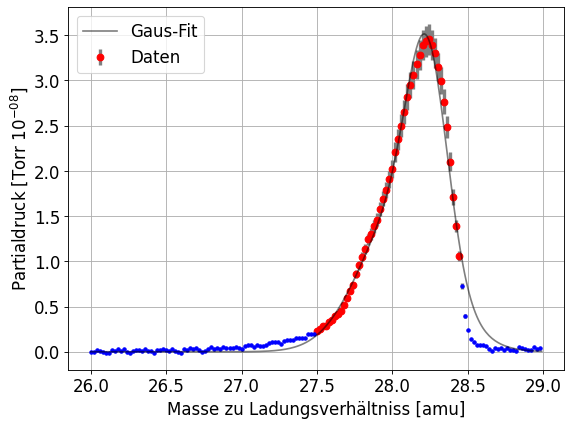

In [20]:
fit20 = gaus2fit(27.5,28.45,'20%',x[0],data[13],err[13],1e8)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 50
    # variables        = 3
    chi-square         = 1432.75424
    reduced chi-square = 30.4841328
    Akaike info crit   = 173.766545
    Bayesian info crit = 179.502614
[[Variables]]
    amplitude:  9.7920e-09 +/- 4.5329e-10 (4.63%) (init = 1.394807e-08)
    center:     28.0503952 +/- 0.00632606 (0.02%) (init = 28.11)
    sigma:      0.20139892 +/- 0.00472105 (2.34%) (init = 0.25)
    fwhm:       0.47425820 +/- 0.01111721 (2.34%) == '2.3548200*sigma'
    height:     1.9397e-08 +/- 1.1865e-09 (6.12%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = -0.483
    C(center, sigma)     = -0.381
    C(amplitude, center) = 0.193


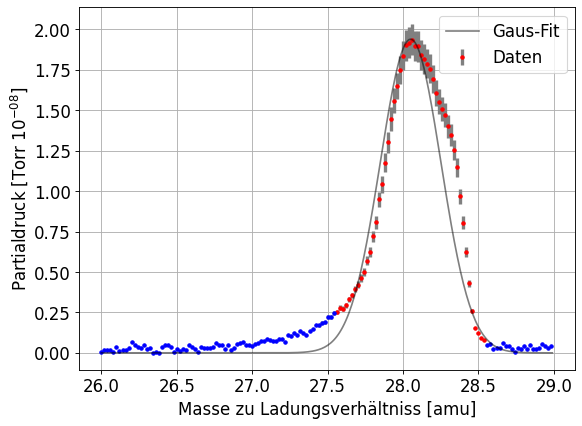

In [21]:
fit30 = gaus1fit(27.55,28.55,'30%',x[0],data[14],err[14],1e8)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 52
    # variables        = 3
    chi-square         = 2720.31865
    reduced chi-square = 55.5167071
    Akaike info crit   = 211.777550
    Bayesian info crit = 217.631281
[[Variables]]
    amplitude:  2.5529e-09 +/- 1.6460e-10 (6.45%) (init = 3.937958e-09)
    center:     28.0427778 +/- 0.00867454 (0.03%) (init = 28.13)
    sigma:      0.20342325 +/- 0.00624645 (3.07%) (init = 0.27)
    fwhm:       0.47902514 +/- 0.01470926 (3.07%) == '2.3548200*sigma'
    height:     5.0066e-09 +/- 4.2184e-10 (8.43%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = -0.505
    C(center, sigma)     = -0.380
    C(amplitude, center) = 0.266


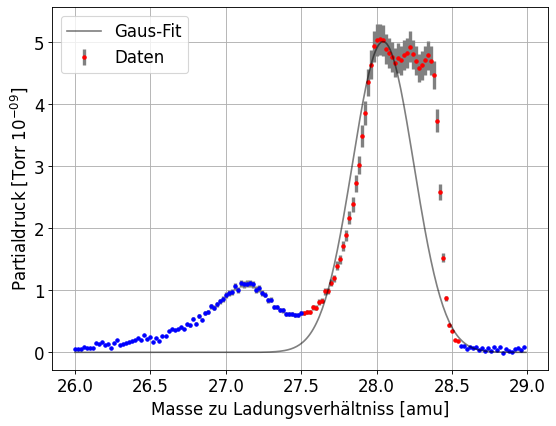

In [22]:
fit40 = gaus1fit(27.52,28.55,'40%',x[0],data[15],err[15],1e9)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 35
    # variables        = 3
    chi-square         = 504.038691
    reduced chi-square = 15.7512091
    Akaike info crit   = 99.3556740
    Bayesian info crit = 104.021718
[[Variables]]
    amplitude:  3.7286e-09 +/- 1.4387e-10 (3.86%) (init = 5.228714e-09)
    center:     28.1379605 +/- 0.00488703 (0.02%) (init = 28.17)
    sigma:      0.14265298 +/- 0.00306100 (2.15%) (init = 0.17)
    fwhm:       0.33592208 +/- 0.00720812 (2.15%) == '2.3548200*sigma'
    height:     1.0427e-08 +/- 5.2879e-10 (5.07%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)    = -0.705
    C(amplitude, sigma) = -0.376


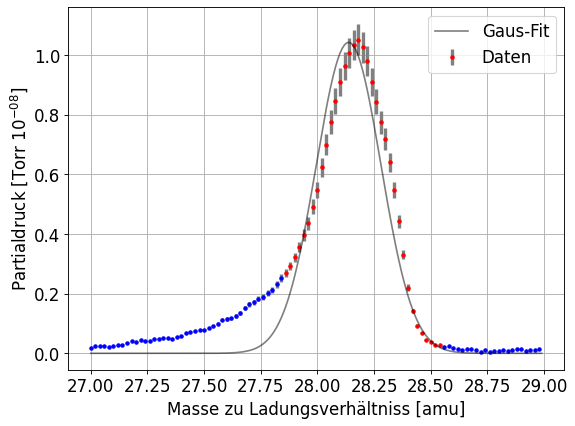

In [23]:
fit50 = gaus1fit(27.852,28.55,'50%',x[1],data[16],err[16],1e8,nrmx=False)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 15
    # variables        = 3
    chi-square         = 35.0203366
    reduced chi-square = 2.91836138
    Akaike info crit   = 18.7181810
    Bayesian info crit = 20.8423316
[[Variables]]
    amplitude:  1.0975e-09 +/- 4.7092e-11 (4.29%) (init = 8.467728e-10)
    center:     28.2650904 +/- 0.00635391 (0.02%) (init = 28.28)
    sigma:      0.10533224 +/- 0.00413321 (3.92%) (init = 0.08)
    fwhm:       0.24803848 +/- 0.00973296 (3.92%) == '2.3548200*sigma'
    height:     4.1569e-09 +/- 1.2572e-10 (3.02%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.894
    C(amplitude, center) = -0.854
    C(amplitude, sigma)  = 0.732


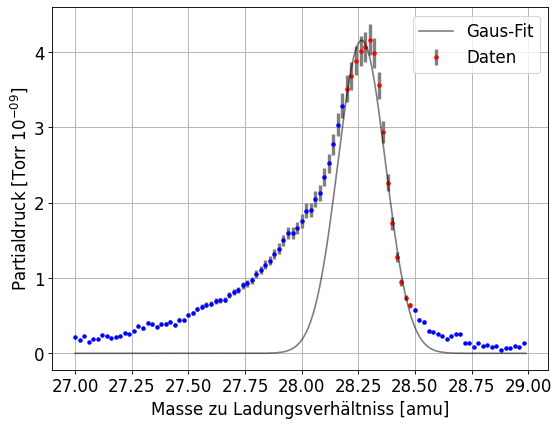

In [24]:
fit60 = gaus1fit(28.2,28.5,'60%',x[1],data[17],err[17],1e9,nrmx=False)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 12
    # variables        = 3
    chi-square         = 3.99640309
    reduced chi-square = 0.44404479
    Akaike info crit   = -7.19414303
    Bayesian info crit = -5.73942309
[[Variables]]
    amplitude:  6.4716e-10 +/- 1.6456e-11 (2.54%) (init = 1.427976e-10)
    center:     27.9083150 +/- 0.00209315 (0.01%) (init = 27.92)
    sigma:      0.12226405 +/- 0.00422138 (3.45%) (init = 0.06)
    fwhm:       0.28790983 +/- 0.00994059 (3.45%) == '2.3548200*sigma'
    height:     2.1117e-09 +/- 3.0851e-11 (1.46%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.926


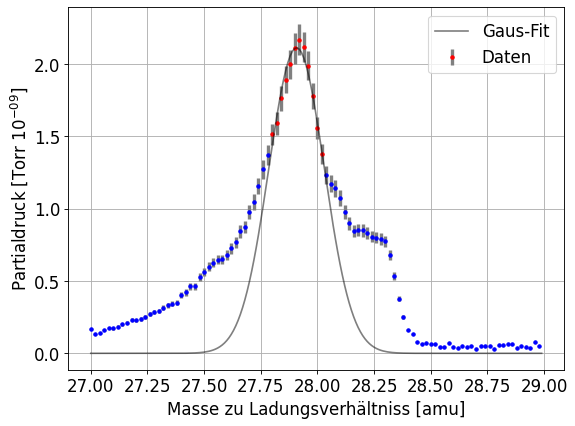

In [25]:
fit70 = gaus1fit(27.79,28.04,'70%',x[1],data[18],err[18],1e9,nrmx=False)#override=True,m1=27.9,m1min=27.7,m1max=28,m2=28.25,m2min=27.9,m2max=28.5)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 13
    # variables        = 3
    chi-square         = 10.0391603
    reduced chi-square = 1.00391603
    Akaike info crit   = 2.64007355
    Bayesian info crit = 4.33492163
[[Variables]]
    amplitude:  4.0729e-10 +/- 1.5090e-11 (3.70%) (init = 1.891714e-10)
    center:     27.7722181 +/- 0.00485810 (0.02%) (init = 27.78)
    sigma:      0.12265219 +/- 0.00529522 (4.32%) (init = 0.08)
    fwhm:       0.28882384 +/- 0.01246930 (4.32%) == '2.3548200*sigma'
    height:     1.3248e-09 +/- 2.5545e-11 (1.93%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.895
    C(amplitude, center) = -0.870
    C(center, sigma)     = -0.818


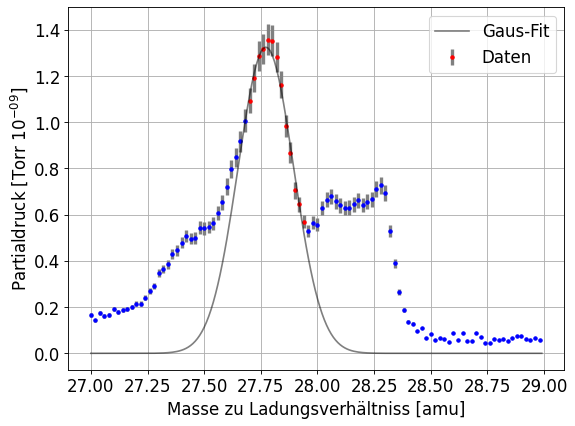

In [26]:
fit80 = gaus1fit(27.69,27.95,'80%',x[1],data[19],err[19],1e9,nrmx=False)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 13
    # variables        = 3
    chi-square         = 5.73923304
    reduced chi-square = 0.57392330
    Akaike info crit   = -4.62910905
    Bayesian info crit = -2.93426098
[[Variables]]
    amplitude:  3.0255e-10 +/- 7.7785e-12 (2.57%) (init = 1.519058e-10)
    center:     27.7743989 +/- 0.00334904 (0.01%) (init = 27.78)
    sigma:      0.11859617 +/- 0.00360616 (3.04%) (init = 0.08)
    fwhm:       0.27927264 +/- 0.00849186 (3.04%) == '2.3548200*sigma'
    height:     1.0177e-09 +/- 1.4845e-11 (1.46%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.878
    C(amplitude, center) = -0.856
    C(center, sigma)     = -0.807


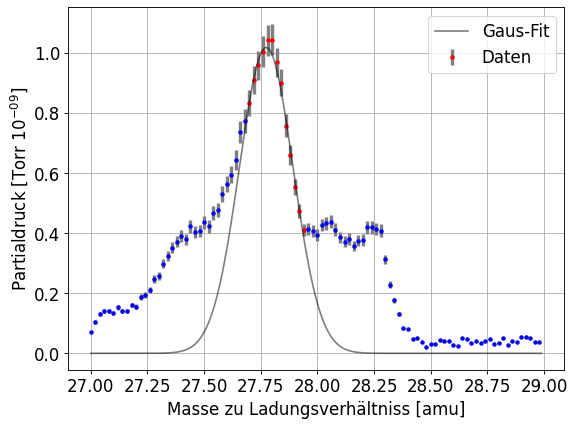

In [27]:
fit90 = gaus1fit(27.69,27.95,'90%',x[1],data[20],err[20],1e9,nrmx=False)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 13
    # variables        = 3
    chi-square         = 3.48943376
    reduced chi-square = 0.34894338
    Akaike info crit   = -11.0977285
    Bayesian info crit = -9.40288038
[[Variables]]
    amplitude:  2.6426e-10 +/- 5.8733e-12 (2.22%) (init = 6.400002e-11)
    center:     27.8105503 +/- 0.00205012 (0.01%) (init = 27.81)
    sigma:      0.13375669 +/- 0.00398462 (2.98%) (init = 0.07)
    fwhm:       0.31497294 +/- 0.00938306 (2.98%) == '2.3548200*sigma'
    height:     7.8818e-10 +/- 9.7192e-12 (1.23%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.928
    C(amplitude, center) = -0.318
    C(center, sigma)     = -0.295


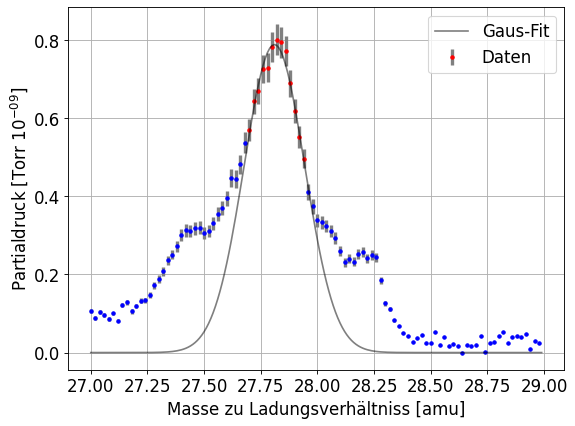

In [28]:
fit100 = gaus1fit(27.69,27.95,'100%',x[1],data[21],err[21],1e9,nrmx=False)

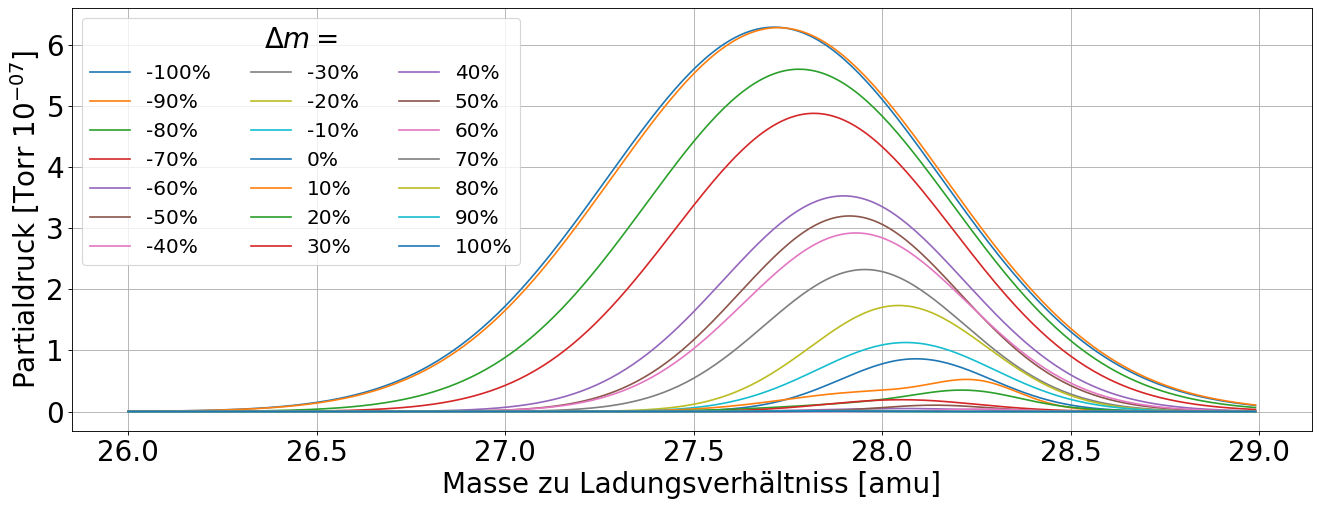

In [29]:
yscale = 1e7
fig = plt.figure(figsize=(20,7),dpi=80,linewidth=50)
plt.rc ('font', size = 25) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 25) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 25) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 25) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 25) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 18) #Schriftgröße der Legende

plt.plot(fit_100v2[0][0],yscale*fit_100v2[0][1],label='-100%')
plt.plot(fit_90[0][0],yscale*fit_90[0][1],label='-90%')
plt.plot(fit_80[0][0],yscale*fit_80[0][1],label='-80%')
plt.plot(fit_70[0][0],yscale*fit_70[0][1],label='-70%')
plt.plot(fit_60[0][0],yscale*fit_60[0][1],label='-60%')
plt.plot(fit_50[0][0],yscale*fit_50[0][1],label='-50%')
plt.plot(fit_40[0][0],yscale*fit_40[0][1],label='-40%')
plt.plot(fit_30[0][0],yscale*fit_30[0][1],label='-30%')
plt.plot(fit_20[0][0],yscale*fit_20[0][1],label='-20%')
plt.plot(fit_10[0][0],yscale*fit_10[0][1],label='-10%')
plt.plot(fit0[0][0],yscale*fit0[0][1],label='0%')
plt.plot(fit10[0][0],yscale*fit10[0][1],label='10%')
plt.plot(fit20[0][0],yscale*fit20[0][1],label='20%')
plt.plot(fit30[0][0],yscale*fit30[0][1],label='30%')
plt.plot(fit40[0][0],yscale*fit40[0][1],label='40%')
plt.plot(fit50[0][0],yscale*fit50[0][1],label='50%')
plt.plot(fit60[0][0],yscale*fit60[0][1],label='60%')
plt.plot(fit70[0][0],yscale*fit70[0][1],label='70%')
plt.plot(fit80[0][0],yscale*fit80[0][1],label='80%')
plt.plot(fit90[0][0],yscale*fit90[0][1],label='90%')
plt.plot(fit100[0][0],yscale*fit100[0][1],label='100%')


plt.xlabel('Masse zu Ladungsverhältniss [amu]')
plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
plt.grid()
plt.legend(ncol=3,title=r'$\Delta m =$')
plt.savefig('Results/verbreiterung.pdf')

In [30]:
peakheight = [
    fit_100v2[1].params['height'].value,
    fit_90[1].params['height'].value,
    fit_80[1].params['height'].value,
    fit_70[1].params['height'].value,
    fit_60[1].params['height'].value,
    fit_50[1].params['height'].value,
    fit_40[1].params['height'].value,
    fit_30[1].params['height'].value,
    fit_20[1].params['height'].value,
    fit_10[1].params['height'].value,
    fit0[1].params['height'].value,
    fit10[1].params['g1_height'].value,
    fit20[1].params['g1_height'].value,
    fit30[1].params['height'].value,
    fit40[1].params['height'].value,
    fit50[1].params['height'].value,
    fit60[1].params['height'].value,
    fit70[1].params['height'].value,
    fit80[1].params['height'].value,
    fit90[1].params['height'].value,
    fit100[1].params['height'].value
    ]
heighterr = [
    fit_100v2[1].params['height'].stderr,
    fit_90[1].params['height'].stderr,
    fit_80[1].params['height'].stderr,
    fit_70[1].params['height'].stderr,
    fit_60[1].params['height'].stderr,
    fit_50[1].params['height'].stderr,
    fit_40[1].params['height'].stderr,
    fit_30[1].params['height'].stderr,
    fit_20[1].params['height'].stderr,
    fit_10[1].params['height'].stderr,
    fit0[1].params['height'].stderr,
    fit10[1].params['g1_height'].stderr,
    fit20[1].params['g1_height'].stderr,
    fit30[1].params['height'].stderr,
    fit40[1].params['height'].stderr,
    fit50[1].params['height'].stderr,
    fit60[1].params['height'].stderr,
    fit70[1].params['height'].stderr,
    fit80[1].params['height'].stderr,
    fit90[1].params['height'].stderr,
    fit100[1].params['height'].stderr
    ]
deltam = [-100,
    -90,
    -80,
    -70,
    -60,
    -50,
    -40,
    -30,
    -20,
    -10,
    0,
    10,
    20,
    30,
    40,
    50,
    60,
    70,
    80,
    90,
    100
    ]

In [31]:
model_lin = lmfit.models.LinearModel()
pars_lin = model_lin.guess(data=peakheight[0:10],x=deltam[0:10])
out_lin =  model_lin.fit(peakheight[0:10],x=deltam[0:10],params=pars_lin,nan_policy='propagate',weights=1/np.array(heighterr[0:10]))


In [32]:
model_exp = lmfit.models.ExponentialModel()
#pars_exp = model_exp.guess(data=peakheight[10:-1],x=deltam[10:-1])
pars_exp = model_exp.make_params()

pars_exp['amplitude'].set(1e-7)
pars_exp['decay'].set(1)

out_exp = model_exp.fit(peakheight[10:-1],x=deltam[10:-1],params=pars_exp,nan_policy='propagate',weights=1/np.array(heighterr[10:-1]))


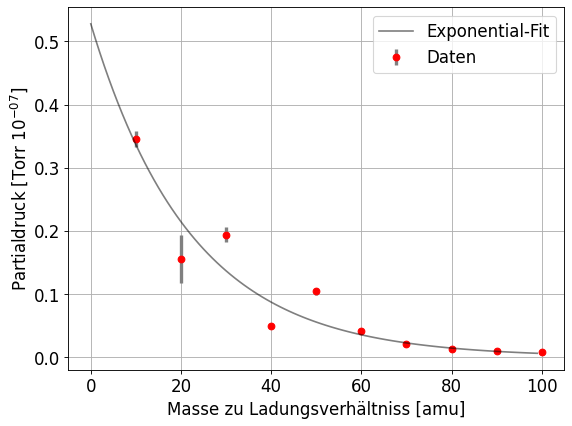

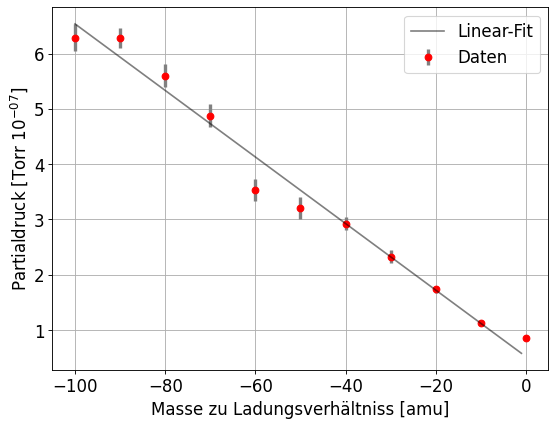

In [33]:
fig = plt.figure(figsize=(8,6),dpi=80,linewidth=50)
yscale = 1e7

plt.rc ('font', size = 15) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 15) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 15) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 15) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 15) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 15) #Schriftgröße der Legende

plt.errorbar(x=deltam[11:21],y=yscale*np.array(peakheight[11:21]),yerr=yscale*np.array(heighterr[11:21]),fmt='o',ecolor='gray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
plt.plot(np.arange(0,100,1),yscale*out_exp.eval(x=np.arange(0,100,1)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Exponential-Fit")

plt.xlabel('Masse zu Ladungsverhältniss [amu]')
plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
plt.grid()
plt.legend()

plt.savefig("Results/klein0.pdf")
plt.show()

fig = plt.figure(figsize=(8,6),dpi=80,linewidth=50)
yscale = 1e7

plt.rc ('font', size = 15) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 15) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 15) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 15) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 15) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 15) #Schriftgröße der Legende

plt.errorbar(x=deltam[0:11],y=yscale*np.array(peakheight[0:11]),yerr=yscale*np.array(heighterr[0:11]),fmt='o',ecolor='gray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
plt.plot(np.arange(-100,0,1),yscale*out_lin.eval(x=np.arange(-100,0,1)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Linear-Fit")


plt.xlabel('Masse zu Ladungsverhältniss [amu]')
plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
plt.grid()
plt.legend()

plt.savefig("Results/größ0.pdf")
plt.show()


In [37]:
for i in range(len(peakheight)):
    print(str(peakheight[i])+"+/-"+str(heighterr[i]) )

6.289990731353122e-07+/-2.4807789128613104e-08
6.282115103631579e-07+/-1.8949768009794384e-08
5.602165106252712e-07+/-2.0287117886037176e-08
4.879955159245396e-07+/-1.9976320874928077e-08
3.529202380332649e-07+/-1.9476709065730478e-08
3.2008556801535403e-07+/-1.9928714013069322e-08
2.9228087635729774e-07+/-1.1223642531848343e-08
2.3241311868837265e-07+/-1.1483019234997918e-08
1.7355834605427616e-07+/-6.63888169318639e-09
1.1298174144918534e-07+/-4.499652148797274e-09
8.630839799039067e-08+/-5.022426358769442e-09
3.45385574559962e-08+/-1.2244115749070807e-09
1.5567553729255574e-08+/-3.775455889755569e-09
1.939656046482803e-08+/-1.1864728151342154e-09
5.006621912227996e-09+/-4.2183771422700646e-10
1.0427364432768184e-08+/-5.28788042325376e-10
4.156874691839827e-09+/-1.257248141451687e-10
2.1116519346412264e-09+/-3.085123945208902e-11
1.3247540742351978e-09+/-2.5545034659198726e-11
1.0177260953048984e-09+/-1.48451650637713e-11
7.881798114873737e-10+/-9.719154666641995e-12


In [38]:
for i in deltam:
    print(i)

-100
-90
-80
-70
-60
-50
-40
-30
-20
-10
0
10
20
30
40
50
60
70
80
90
100
